In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets

transforms = transforms.ToTensor()

In [2]:
# loading datasets

train_dataset = datasets.MNIST(root = 'data', train = True, download = True, transform = transforms)
test_dataset = datasets.MNIST(root = 'data', train = False, download = True, transform = transforms)

In [3]:
# data loading

num_workers = 0
batch_size = 20

train_load = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers)
test_load = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers)

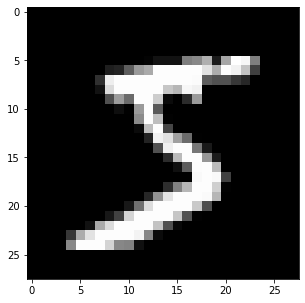

In [4]:
# Visulaise data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_load)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = 'gray')

In [15]:

import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class DenoiseConv(nn.Module):
    def __init__(self):
        super(DenoiseConv, self).__init__()
        # encoder layers
    
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
       
        self.pool = nn.MaxPool2d(2, 2)
        
        #decoder layers
        self.deconv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  
        self.deconv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.deconv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        
        self.convt = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
       
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.sigmoid(self.convt(x))
                
        return x


model = DenoiseConv()
print(model)

DenoiseConv(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (deconv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (deconv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (convt): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [17]:
#Training

n_epochs = 20

noise_factor = 0.5

for epoch in range(1,n_epochs+1):
    train_loss = 0
    
    for data in train_load:
        images, _ = data
        
        #adding noise
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        optimizer.zero_grad()
        output = model(noisy_imgs)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        
    train_loss = train_loss/len(train_load)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss}')
        
    

Epoch: 1 	Training Loss: 0.9739498243605097
Epoch: 2 	Training Loss: 0.6965130045885841
Epoch: 3 	Training Loss: 0.6503763692950209
Epoch: 4 	Training Loss: 0.624975223566095
Epoch: 5 	Training Loss: 0.6072679427887002
Epoch: 6 	Training Loss: 0.5948697768275937
Epoch: 7 	Training Loss: 0.585391014876465
Epoch: 8 	Training Loss: 0.577940847625335
Epoch: 9 	Training Loss: 0.5721767547229926
Epoch: 10 	Training Loss: 0.5656581980735064
Epoch: 11 	Training Loss: 0.5606393891076247
Epoch: 12 	Training Loss: 0.5557737484077613
Epoch: 13 	Training Loss: 0.5510850672796369
Epoch: 14 	Training Loss: 0.5475993528589607
Epoch: 15 	Training Loss: 0.5441605122511586
Epoch: 16 	Training Loss: 0.5418313380579154
Epoch: 17 	Training Loss: 0.539406762085855
Epoch: 18 	Training Loss: 0.5368432339156667
Epoch: 19 	Training Loss: 0.5358286886662245
Epoch: 20 	Training Loss: 0.533228329718113


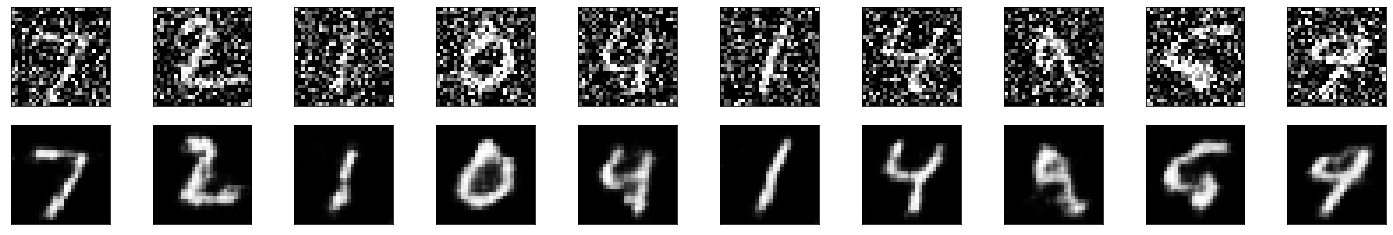

In [18]:
dataiter = iter(test_load)
images, labels = dataiter.next()

# adding noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

output = model(noisy_imgs)
noisy_imgs = noisy_imgs.numpy()

output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

# plotting the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)